In [2]:
! pip install sklearn

Traceback (most recent call last):
  File "/usr/local/bin/pip", line 5, in <module>
    from pip._internal.cli.main import main
ImportError: No module named pip._internal.cli.main


In [5]:
! pip install scikit-image

Traceback (most recent call last):
  File "/usr/local/bin/pip", line 5, in <module>
    from pip._internal.cli.main import main
ImportError: No module named pip._internal.cli.main


In [2]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git


Looking in indexes: https://build-nexus.prod.crto.in/repository/moab.pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://build-nexus.prod.crto.in/repository/moab.pypi/simple
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ccdxtneh
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ccdxtneh
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 6.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 146.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 104.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3

In [3]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 2.0.1+cu117


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [2]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [3]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.




Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [9]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fc8a20d0550>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [10]:

clip.tokenize("kd")

tensor([[49406, 15597, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [11]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer",
    "phantom": "a photo of a black phantom",
    "moon": "a photo of a beautiful moon",
    "cell": "a photo of a cell",
    "text": "text",
}



<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>


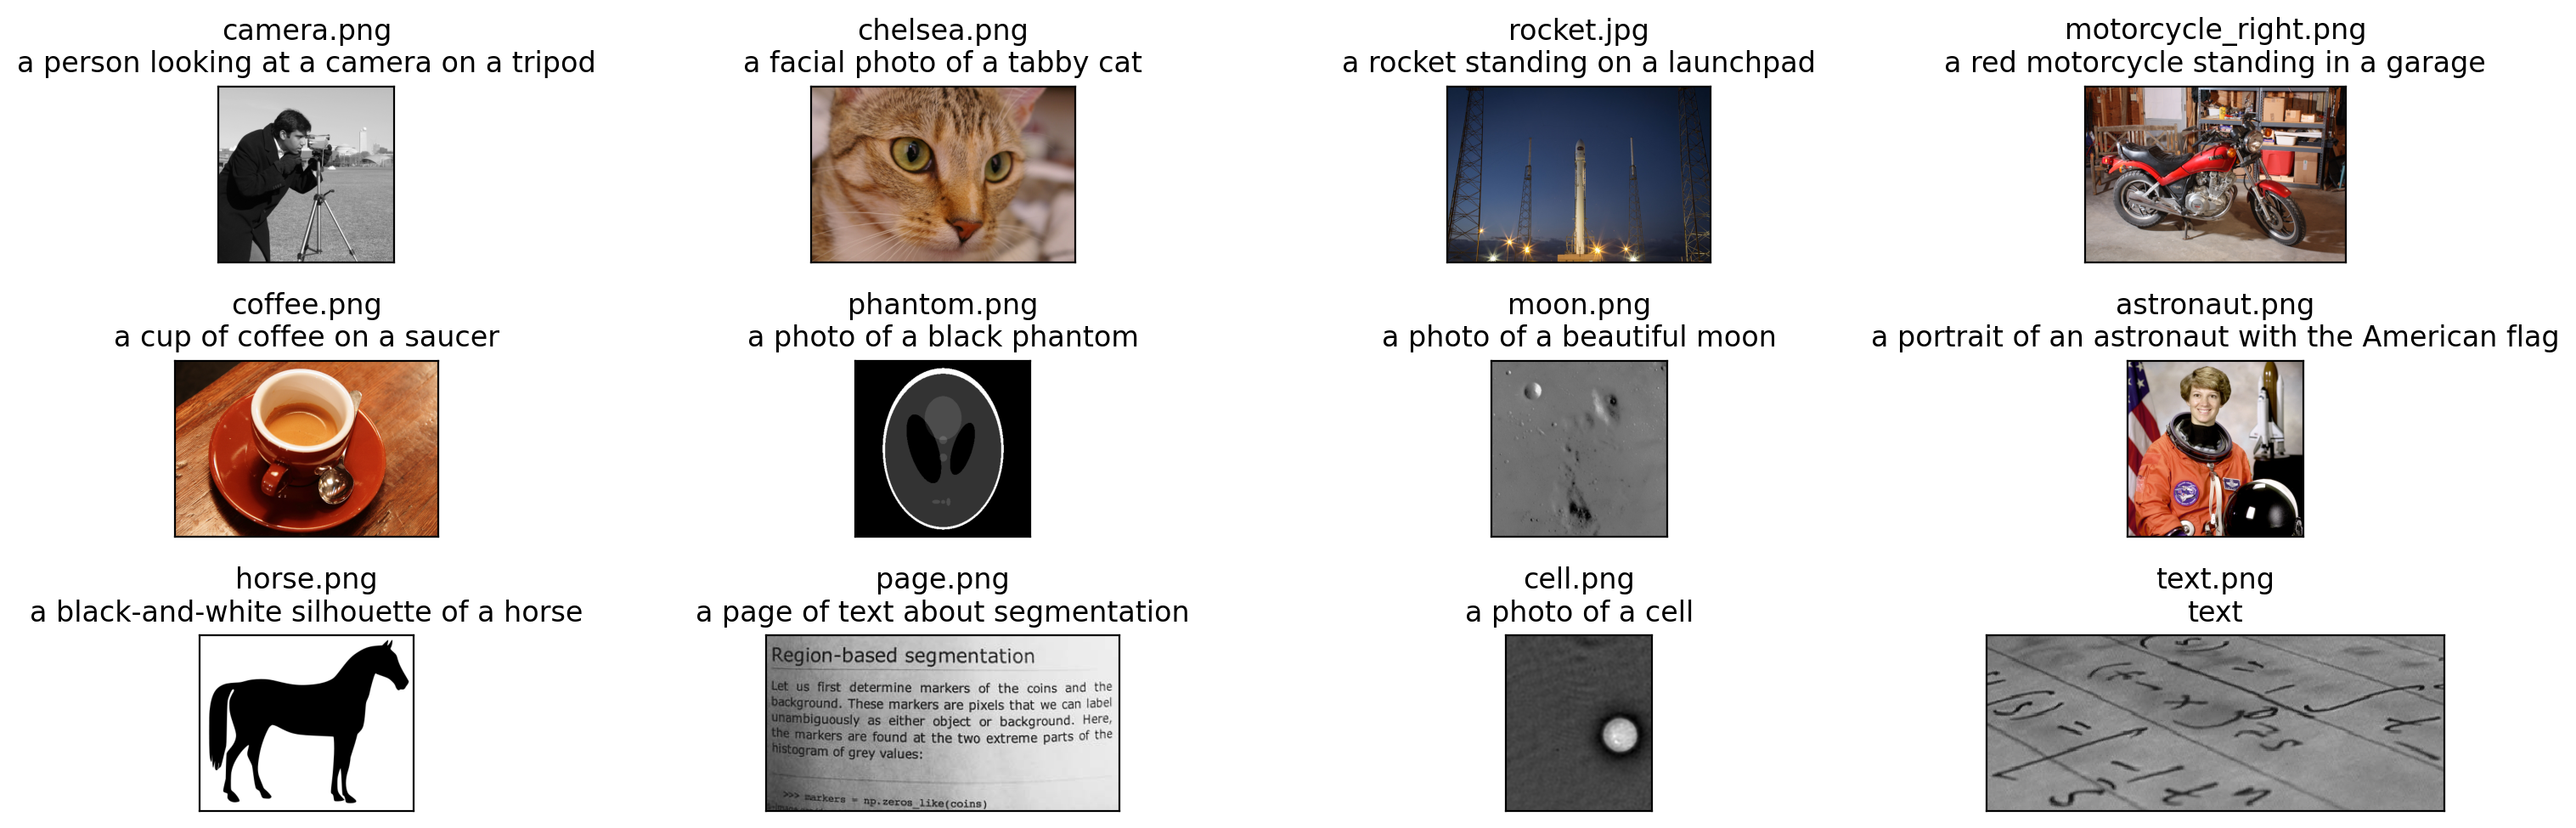

In [87]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(3, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    print(type(image))
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [13]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()
print("image_input size:", image_input.size())
print("text tokens size:", text_tokens.size())


image_input size: torch.Size([12, 3, 224, 224])
text tokens size: torch.Size([12, 77])


In [14]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()
    
print("image_feautres size: ",image_features.size())
print("text_feautres size: ",text_features.size())

image_feautres size:  torch.Size([12, 512])
text_feautres size:  torch.Size([12, 512])


## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [15]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T


Text(0.5, 1.0, 'Cosine similarity between text and image features')

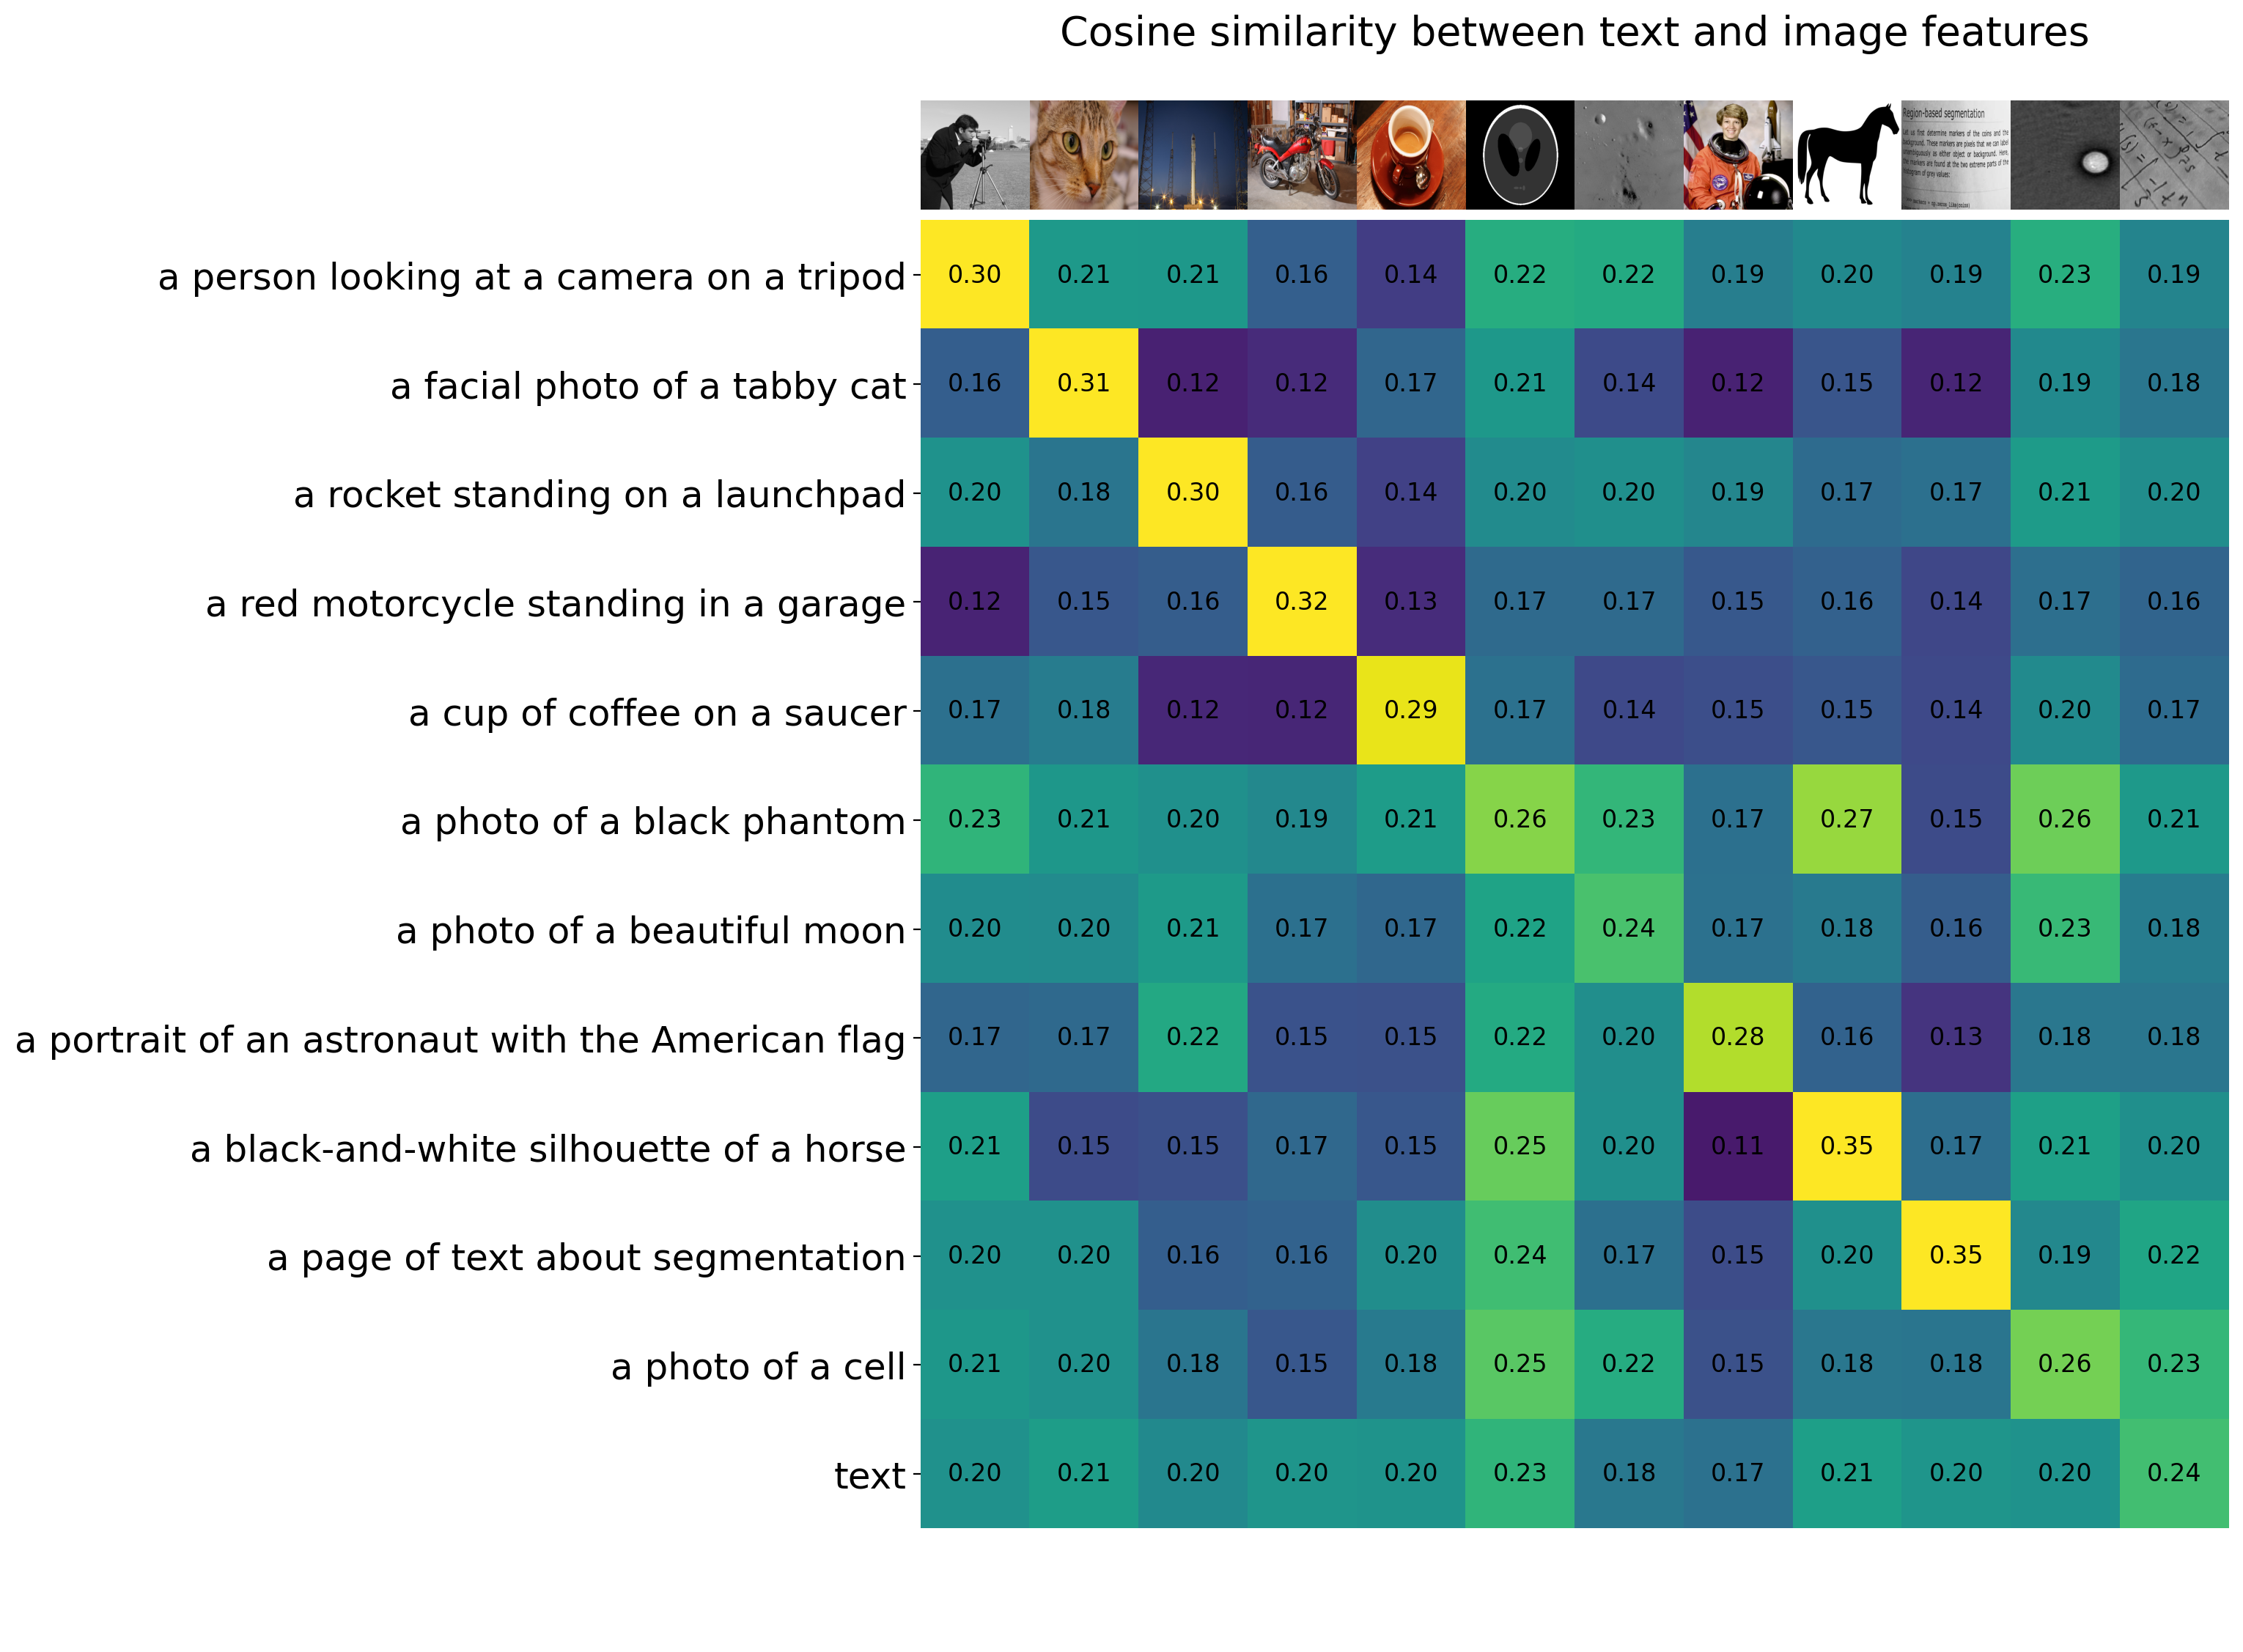

In [16]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [17]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169001437/169001437 [00:05<00:00, 28945947.05it/s]


Extracting /home/a.badaoui/.cache/cifar-100-python.tar.gz to /home/a.badaoui/.cache


In [18]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [19]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

ValueError: num must be an integer with 1 <= num <= 16, not 17

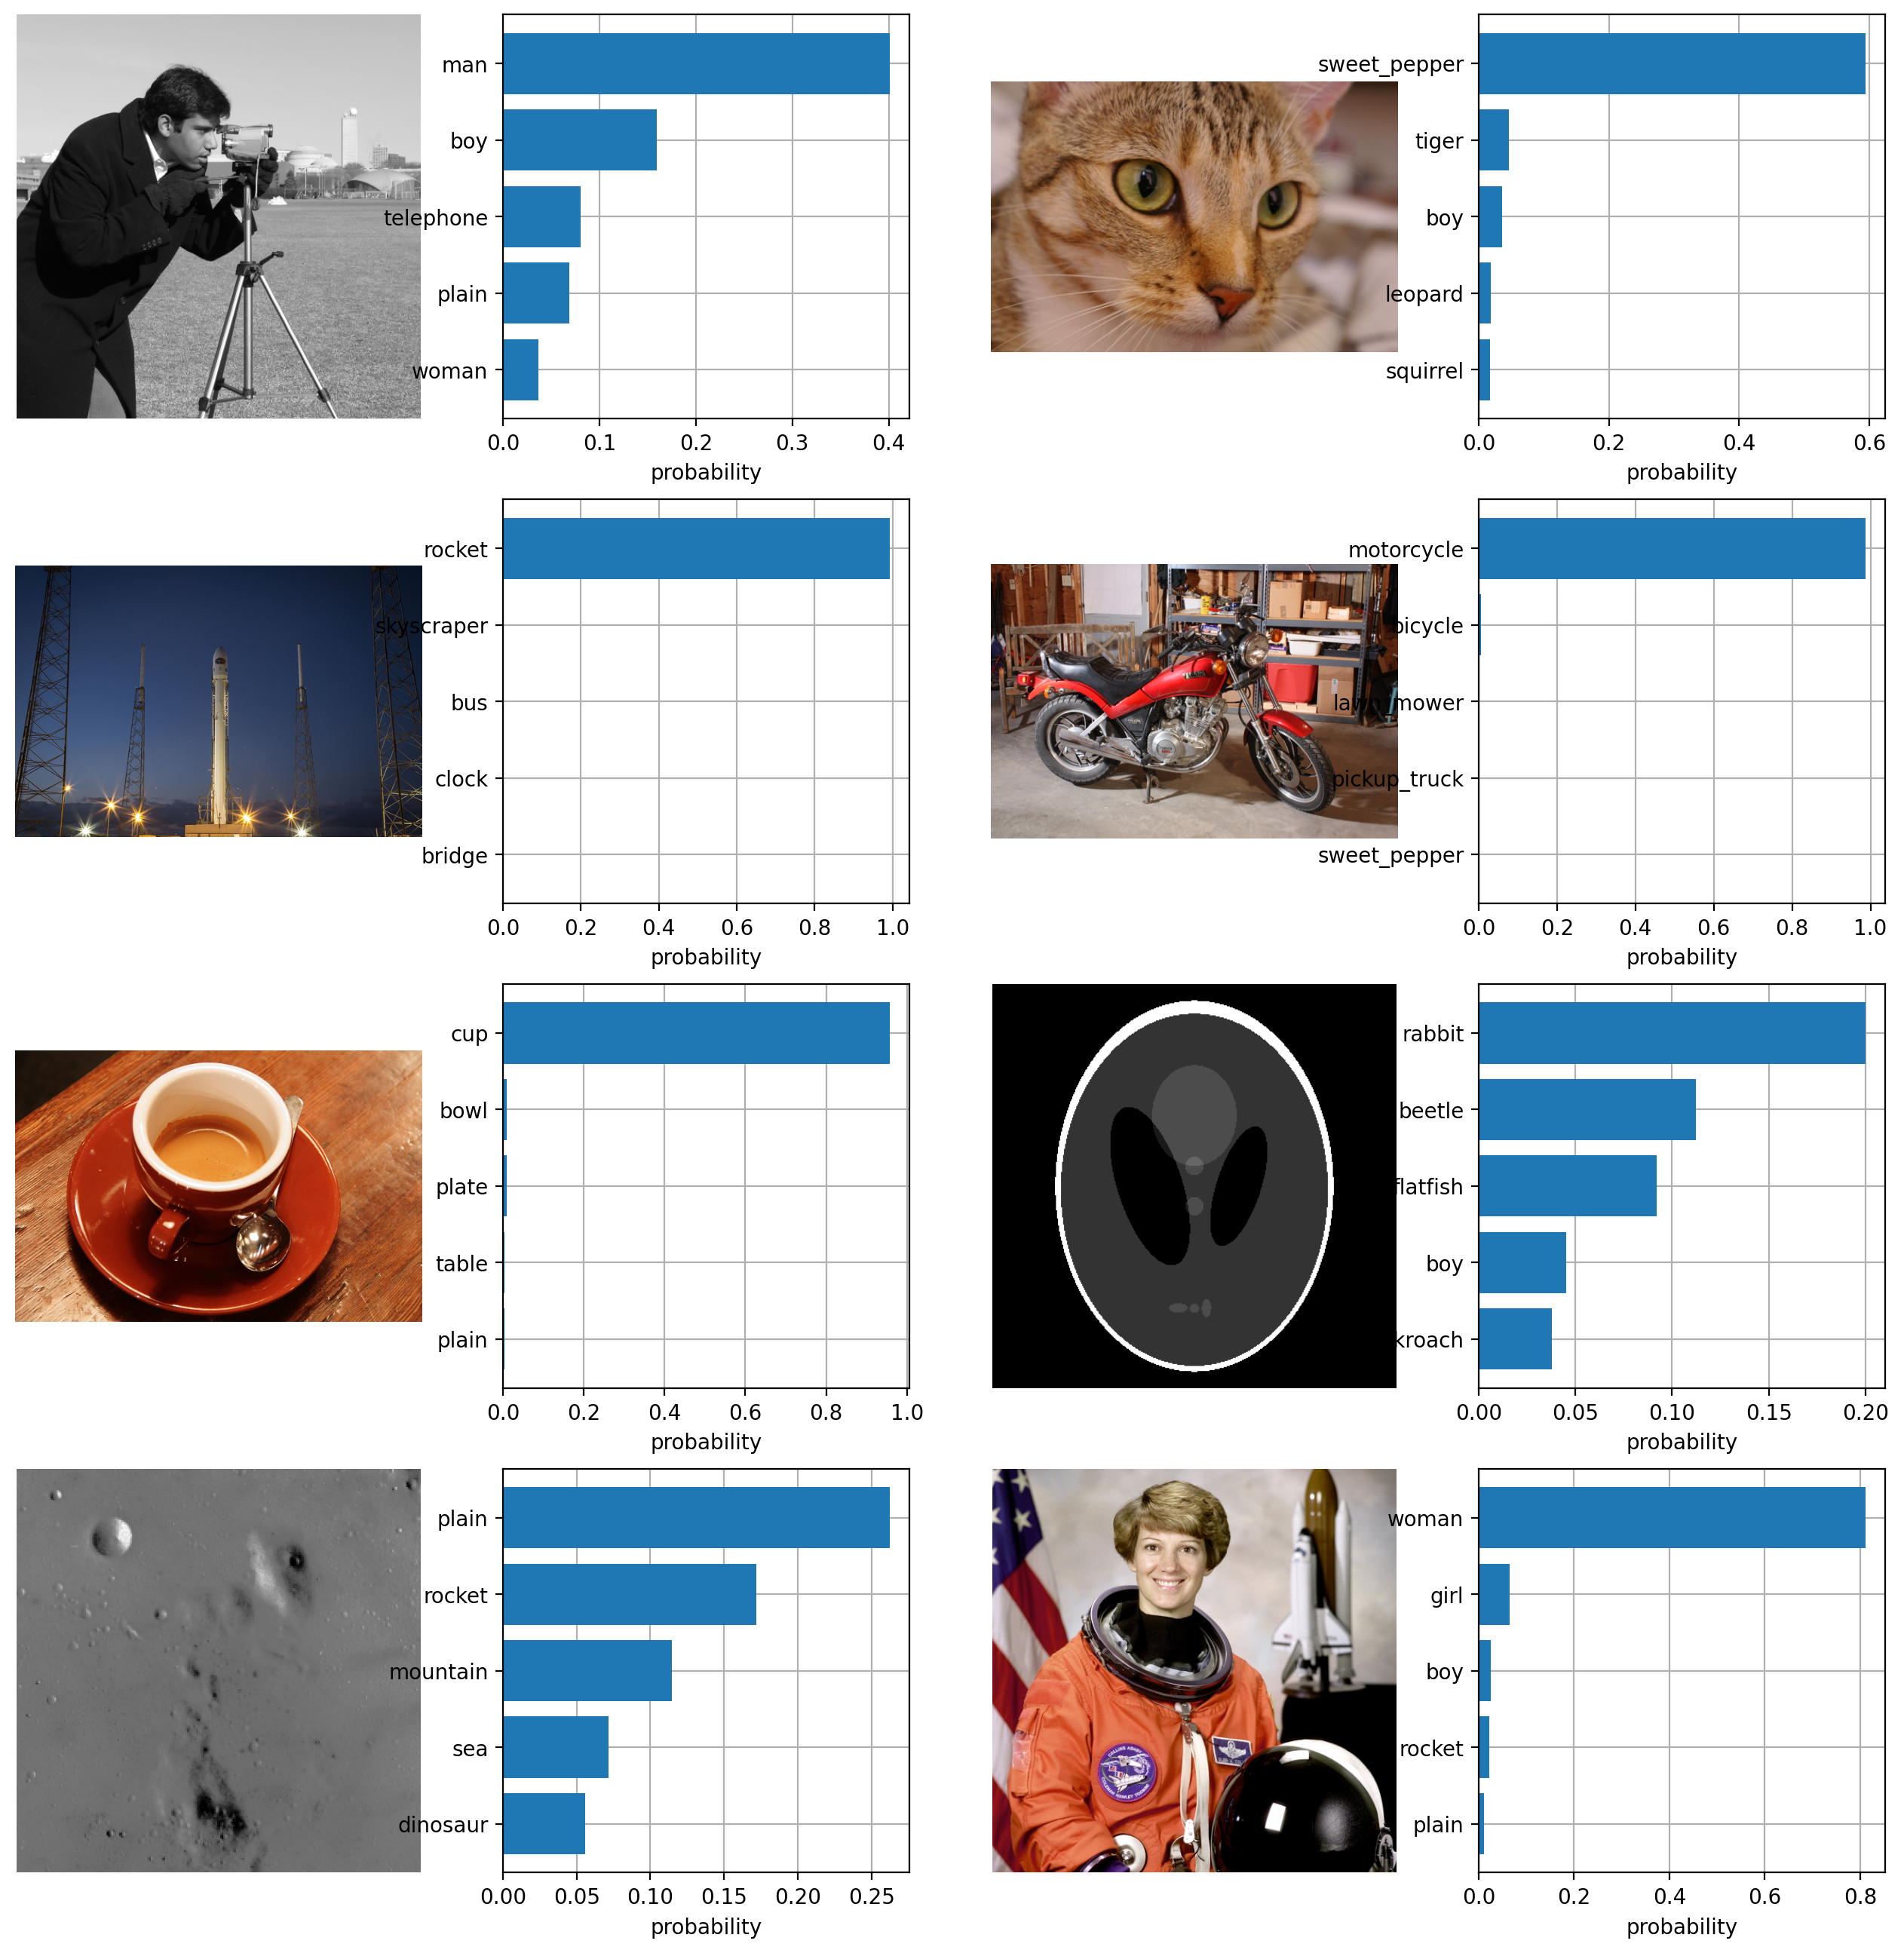

In [20]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

_________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# CLIP On Fashion MNIST (whitout fine-tuning)

In [4]:
import clip
import torch
import torchvision
import numpy as np

# Load the CLIP model and set it to evaluation mode
model, preprocess = clip.load("ViT-B/32")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

# Download the Fashion MNIST dataset
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True)

# Encode the class names (labels) using clip.tokenize
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']





In [5]:
# image, label = train_dataset[5]
# print(image.size)
# image = image.resize((224, 224))
# image
# transform_pil_tensor = transforms.Compose([transforms.PILToTensor()])
# image = transform_pil_tensor(image)
# image

In [6]:
num_samples_to_select = 20
test_dataset = [(image, label) for i, (image, label) in enumerate(test_dataset) if i < num_samples_to_select]


In [7]:
# # Select a sample image from the Fashion MNIST dataset
# image, label = train_dataset[0]
# image = image.resize((224, 224))
# transform_pil_tensor = transforms.Compose([transforms.PILToTensor()])
# image = transform_pil_tensor(image)
# image




In [8]:
images = []
original_images = []
correct_labels = []
# transform_pil_tensor = transforms.Compose([transforms.PILToTensor()])
for image, label in test_dataset:
    image = image.resize((224, 224))
    original_images.append(image)
    images.append(preprocess(image))
    correct_labels.append(label)
    

In [9]:
text_tokens = clip.tokenize(["This is a "+ label for label in class_names]).cuda()
image_input = torch.tensor(np.stack(images)).cuda()


In [10]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [11]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [12]:
# Step 1: Compute cosine similarity
similarity_ = similarity.argmax(axis=0)

# Step 2: Get the predicted labels
predicted_labels = [class_names[i] for i in similarity_]

# Step 3: Calculate accuracy
correct_predictions = sum([1 for i, (_, label) in enumerate(test_dataset) if predicted_labels[i] == class_names[label]])
accuracy = correct_predictions / len(test_dataset)

print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.65


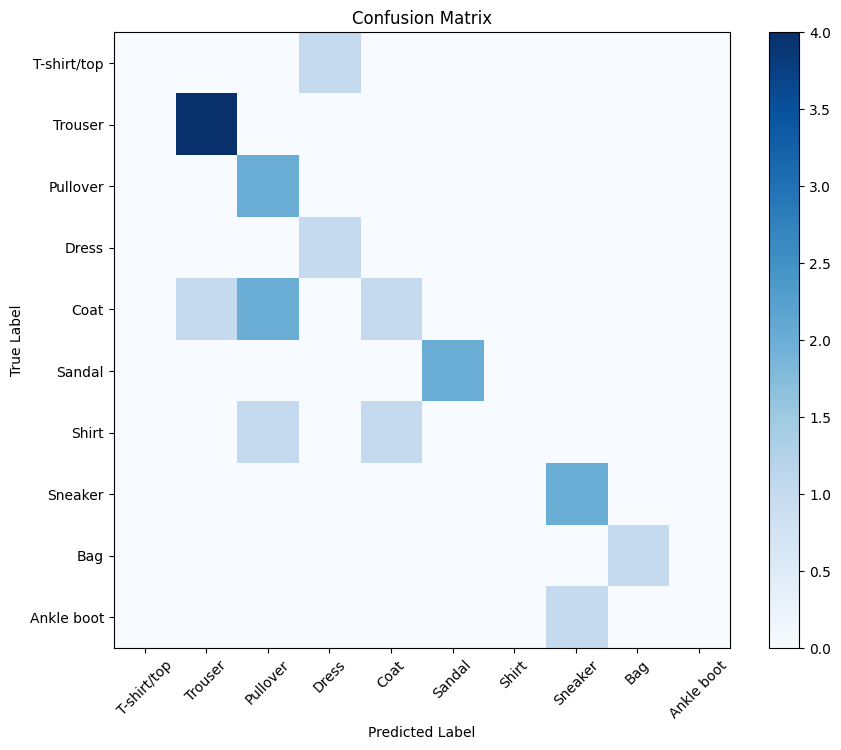

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Rest of the code to load the CLIP model, preprocess data, and compute similarity

# Step 1: Compute cosine similarity
similarity_ = similarity.argmax(axis=0)

# Step 2: Get the predicted labels
predicted_labels = [class_names[i] for i in similarity_]

# Step 3: Get the ground truth labels
ground_truth_labels = [class_names[label] for _, label in test_dataset]

# Step 4: Create a confusion matrix
num_classes = len(class_names)
confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

for true_label, predicted_label in zip(ground_truth_labels, predicted_labels):
    true_idx = class_names.index(true_label)
    predicted_idx = class_names.index(predicted_label)
    confusion_matrix[true_idx][predicted_idx] += 1

# Step 5: Plot the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix, interpolation='nearest', cmap='Blues')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [14]:
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

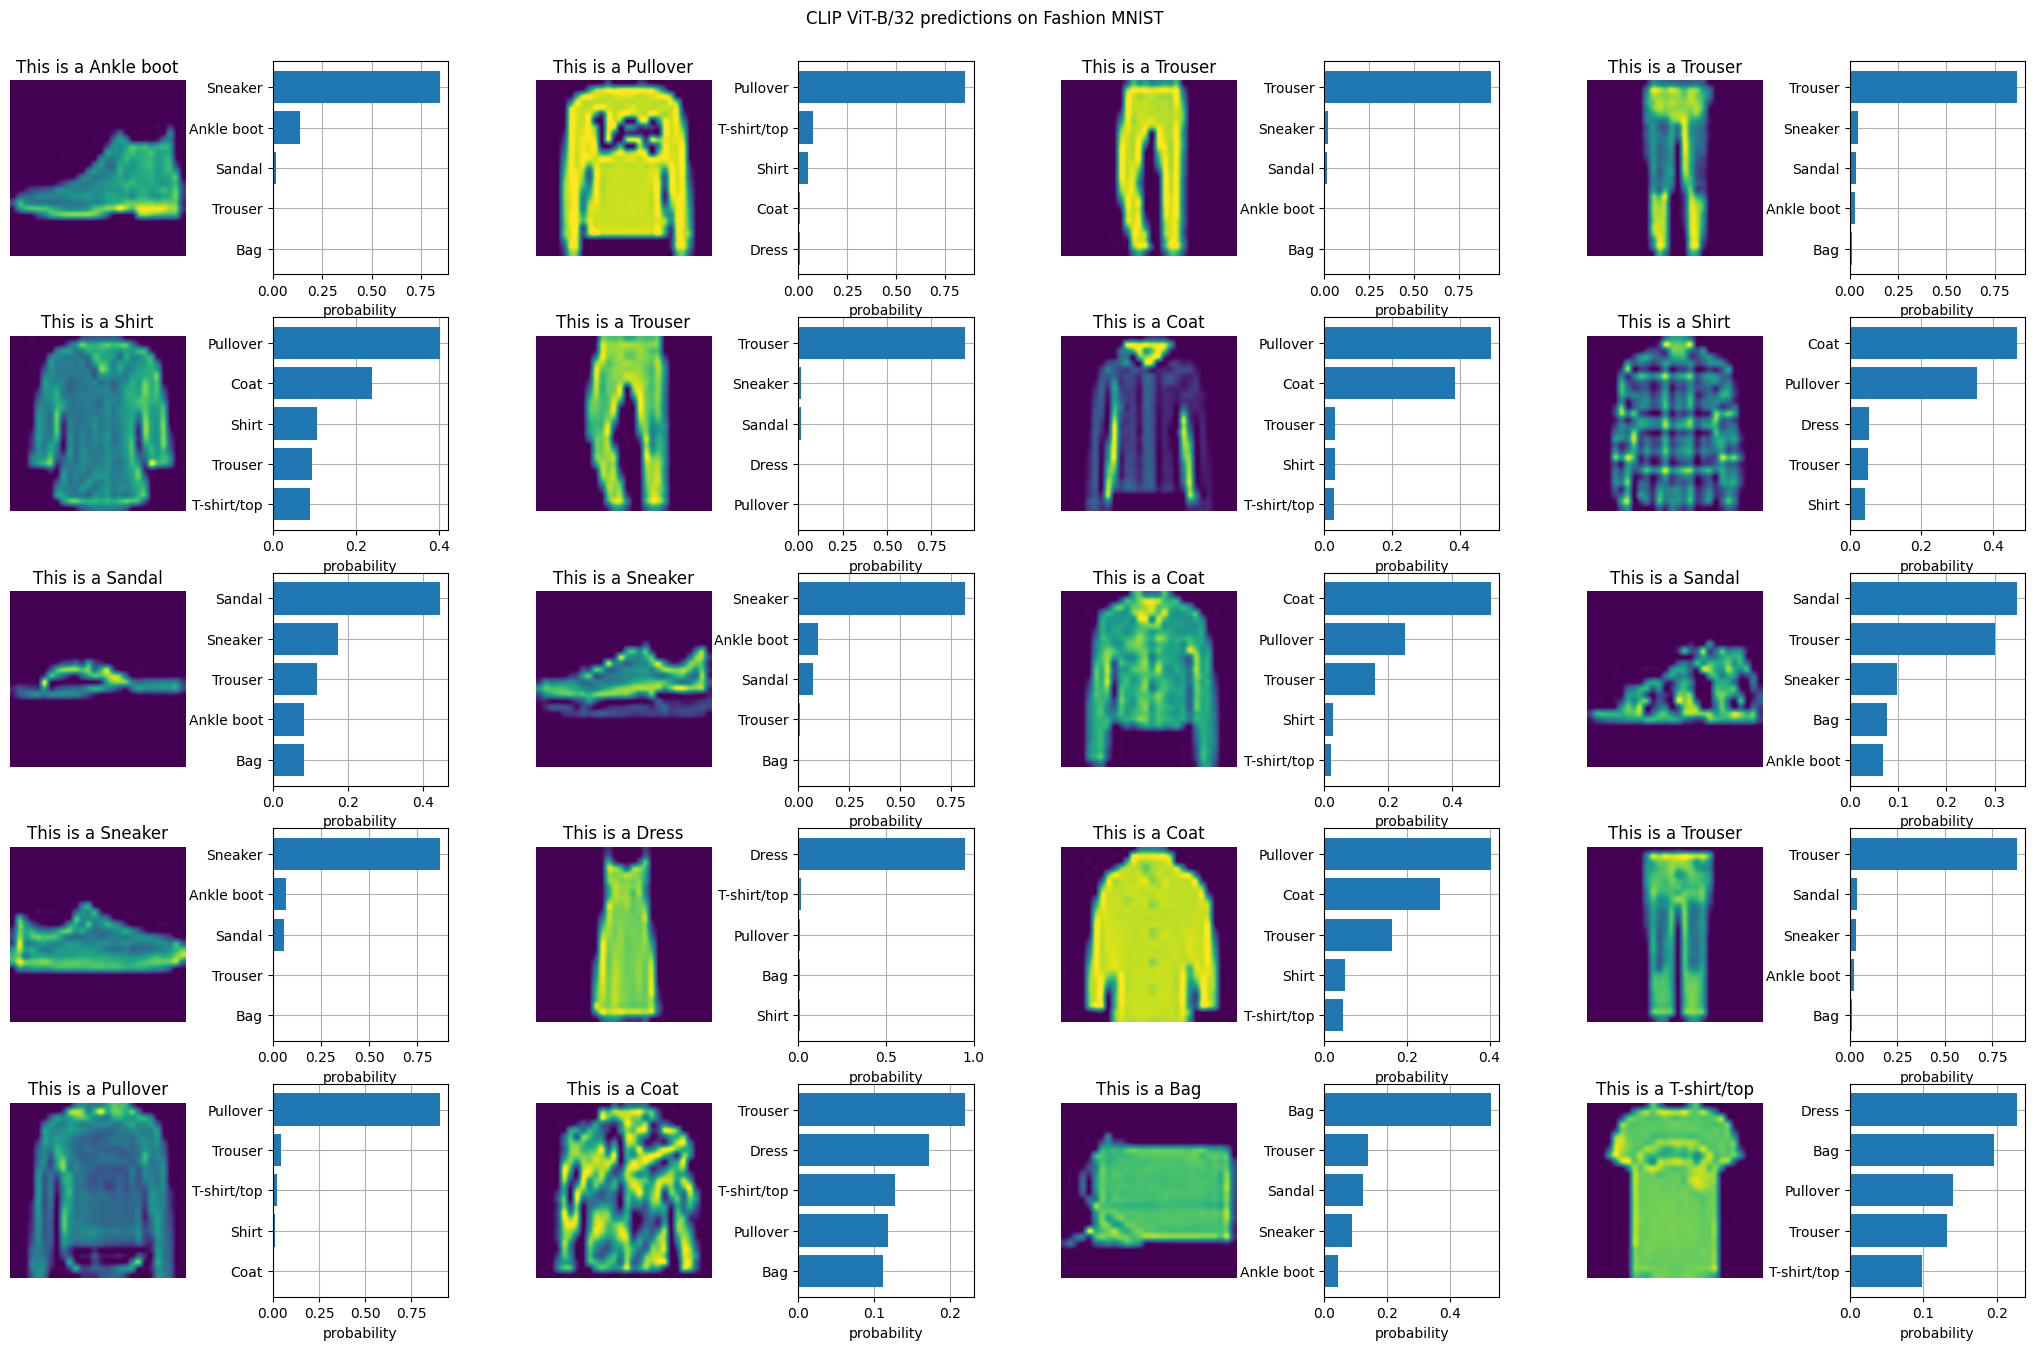

In [15]:
plt.figure(figsize=(26, 26))


for i, image in enumerate(original_images):
    plt.subplot(8, 8, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title("This is a "+ class_names[correct_labels[i]])

    plt.subplot(8, 8, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [class_names[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")
    
plt.suptitle("CLIP ViT-B/32 predictions on Fashion MNIST",x=0.5,y=0.9)
plt.subplots_adjust(wspace=0.5)
plt.show()


# Comparaison of the CLIP model versions

In [153]:
# Download the Fashion MNIST dataset
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True)

# Encode the class names (labels) using clip.tokenize
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
accuracies=[]
num_samples_to_select = 200
test_dataset = [(image, label) for i, (image, label) in enumerate(test_dataset) if i < num_samples_to_select]



for model_name in clip.available_models():
    # Load the CLIP model and set it to evaluation mode
    model, preprocess = clip.load(model_name)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.eval()
    images = []
    original_images = []
    correct_labels = []
    # transform_pil_tensor = transforms.Compose([transforms.PILToTensor()])
    for image, label in test_dataset:
        image = image.resize((224, 224))
        original_images.append(image)
        images.append(preprocess(image))
        correct_labels.append(label)
    text_tokens = clip.tokenize(["This is a "+ label for label in class_names]).cuda()
    image_input = torch.tensor(np.stack(images)).cuda()
    with torch.no_grad():
        image_features = model.encode_image(image_input).float()
        text_features = model.encode_text(text_tokens).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    # Step 1: Compute cosine similarity
    similarity_ = similarity.argmax(axis=0)

    # Step 2: Get the predicted labels
    predicted_labels = [class_names[i] for i in similarity_]

    # Step 3: Calculate accuracy
    correct_predictions = sum([1 for i, (_, label) in enumerate(test_dataset) if predicted_labels[i] == class_names[label]])
    accuracy = correct_predictions / len(test_dataset)
    accuracies.append(accuracy)
    


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.39 GiB (GPU 0; 15.77 GiB total capacity; 7.94 GiB already allocated; 2.06 GiB free; 12.63 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

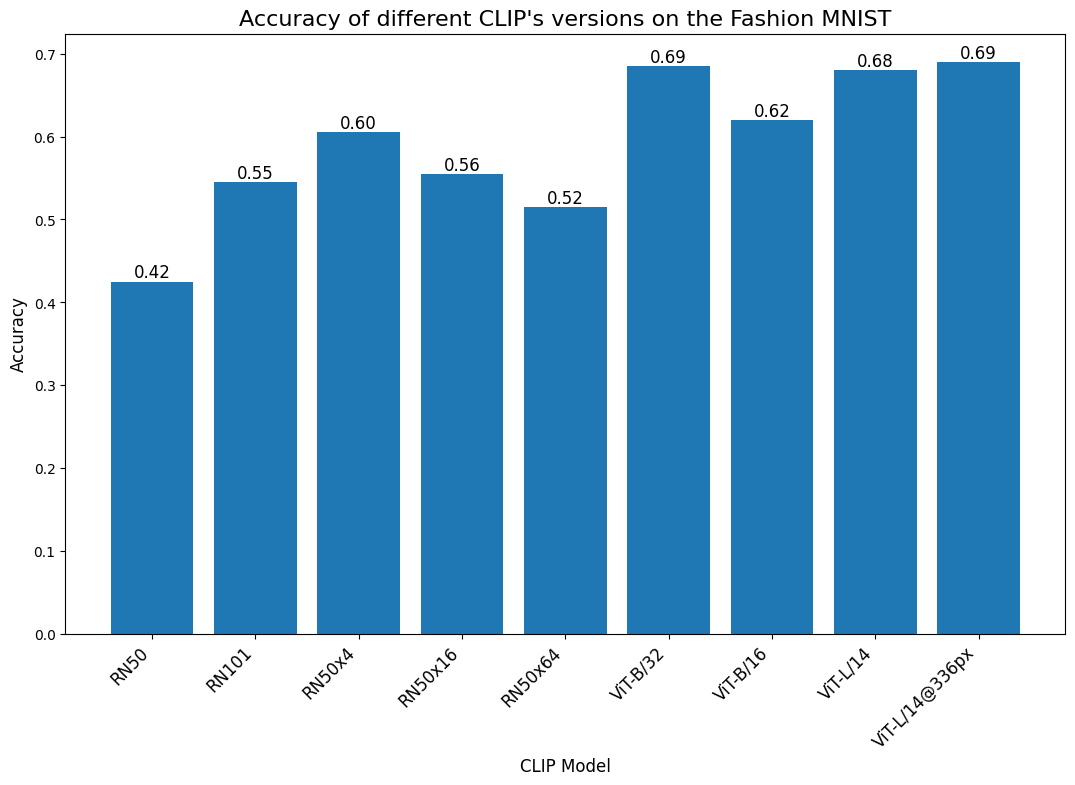

In [139]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes([0, 0, 1, 1])
models = clip.available_models()

# Plot the bars
bars = ax.bar(models, accuracies)

# Add text annotations above each bar
for bar, accuracy in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{accuracy:.2f}', ha='center', va='bottom', fontsize=12)

ax.set_title("Accuracy of different CLIP's versions on the Fashion MNIST", fontsize=16)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_xlabel("CLIP Model", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=12)

plt.show()


# Contrastive Loss function

0.0


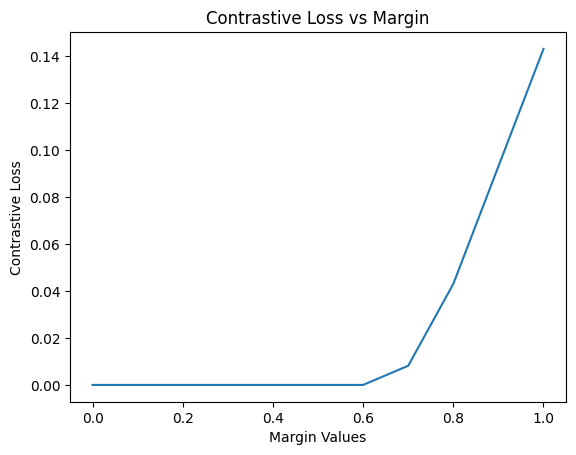

In [20]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Example vectors (batch size = 2)
image_features = torch.tensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6]])
text_features = torch.tensor([[0.4, 1.2, 0.3], [11.4, 44.9, 0.2]]) 

# Define the ContrastiveLoss class
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=0.2):  # Decrease the margin value
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, image_features, text_features):
        # Normalize features
        image_features = nn.functional.normalize(image_features, dim=-1, p=2)
        text_features = nn.functional.normalize(text_features, dim=-1, p=2)

        # Compute pairwise similarity
        similarity = torch.matmul(image_features, text_features.t())

        # Generate target labels (1 for similar pairs, 0 for dissimilar pairs)
        labels = torch.eye(similarity.size(0), device=similarity.device)
        labels = (labels + 1) % 2  # Invert 1s and 0s

        # Calculate contrastive loss
        loss_contrastive = 0.5 * labels * similarity + 0.5 * (1 - labels) * torch.clamp(self.margin - similarity, min=0)
        return torch.mean(torch.diagonal(loss_contrastive))

# Calculate the loss for different margin values
margin_values = [i * 0.1 for i in range(int(1/0.1) + 1)]
loss_values = []

for margin in margin_values:
    contrastive_loss = ContrastiveLoss(margin=margin)
    loss = contrastive_loss(image_features, text_features)
    loss_values.append(loss.item())
    

# Plot the loss values against the margin values
plt.plot(margin_values, loss_values)
print(loss_values[0])
plt.xlabel('Margin Values')
plt.ylabel('Contrastive Loss')
plt.title('Contrastive Loss vs Margin')
plt.show()


# A Simple Custom Model 

Epoch 1/10, Loss: 0.7483447342145222, Training Accuracy: 0.746, Validation Accuracy: 0.822
Epoch 2/10, Loss: 0.47056809367818964, Training Accuracy: 0.8307037037037037, Validation Accuracy: 0.8483333333333334
Epoch 3/10, Loss: 0.41991677251058046, Training Accuracy: 0.8512592592592593, Validation Accuracy: 0.8596666666666667
Epoch 4/10, Loss: 0.3909671103385174, Training Accuracy: 0.8615185185185186, Validation Accuracy: 0.8676666666666667
Epoch 5/10, Loss: 0.36963863333945884, Training Accuracy: 0.8674444444444445, Validation Accuracy: 0.8743333333333333
Epoch 6/10, Loss: 0.3531299713117726, Training Accuracy: 0.8751111111111111, Validation Accuracy: 0.8723333333333333
Epoch 7/10, Loss: 0.3398901653577815, Training Accuracy: 0.8791111111111111, Validation Accuracy: 0.887
Epoch 8/10, Loss: 0.32672181039988235, Training Accuracy: 0.8852592592592593, Validation Accuracy: 0.8826666666666667
Epoch 9/10, Loss: 0.31671413941308857, Training Accuracy: 0.8877407407407407, Validation Accuracy: 

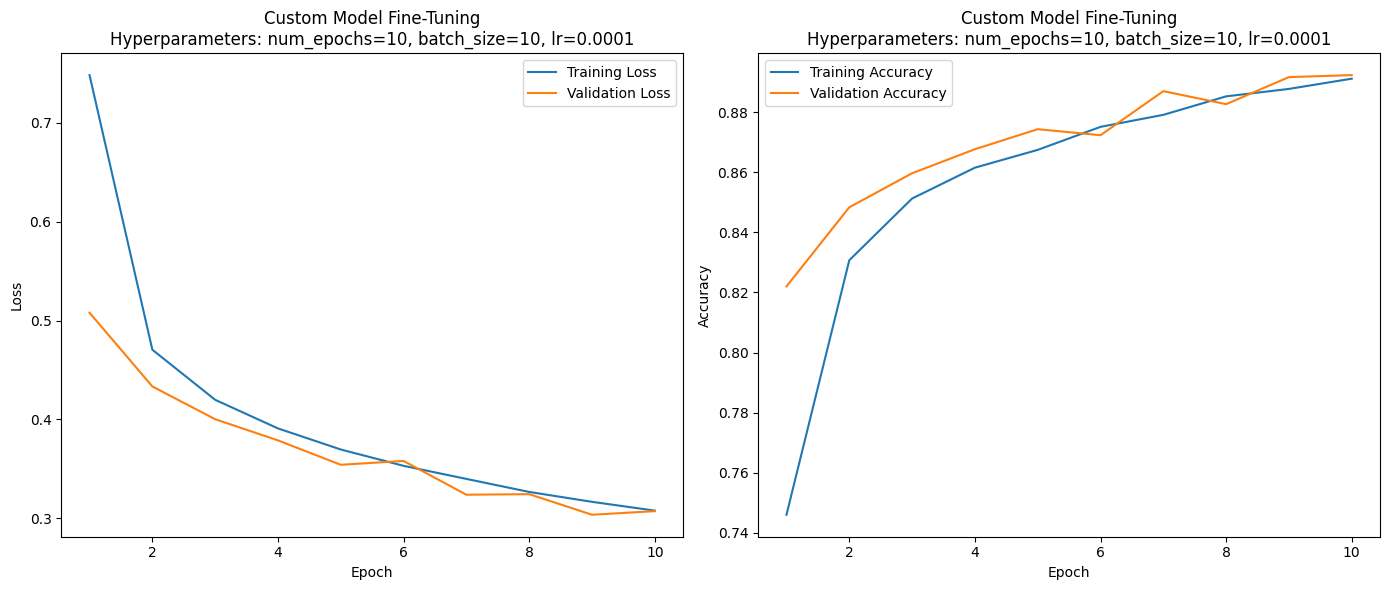

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns


# Define your custom model
class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        # Define your custom model architecture here
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )
        self.classifier = nn.Linear(7 * 7 * 32, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate your custom model and move it to the appropriate device (CPU or GPU)
num_classes = 10  # Number of classes in Fashion MNIST
model = CustomModel(num_classes)
model = model.to(device)

# Custom dataset class for Fashion MNIST
class FashionMNISTDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize images to (28, 28) for the custom model
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to range [-1, 1]
])

train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Reduce the batch size further
batch_size = 10

images = []
original_images = []
correct_labels = []
for image, label in train_dataset:
    original_images.append(image)
    images.append(image)
    correct_labels.append(label)

# Select a subset of the Fashion MNIST dataset for training
num_samples = 30000  # You can adjust this number to control the size of the training dataset
train_dataset = FashionMNISTDataset(list(zip(images[:num_samples], correct_labels[:num_samples])), transform=None)

# Split the data into training and validation sets
val_size = int(0.1 * len(train_dataset))
train_dataset, val_dataset = random_split(train_dataset, [len(train_dataset) - val_size, val_size])

# Create DataLoader with the reduced batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Fine-tune the custom model using Fashion MNIST
lr = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

num_epochs = 10
train_losses = torch.zeros(num_epochs)
train_accuracies = torch.zeros(num_epochs)
val_losses = torch.zeros(num_epochs)
val_accuracies = torch.zeros(num_epochs)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute top-1 accuracy
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_images)
            val_loss+= criterion(val_outputs, val_labels).item()

            val_preds = torch.argmax(val_outputs, dim=1)
            val_correct += (val_preds == val_labels).sum().item()
    
    # Append loss and accuracy values for plotting
    train_losses[epoch] = running_loss / len(train_loader)
    train_accuracies[epoch] = correct / len(train_dataset)
    val_losses[epoch] = val_loss / len(val_loader)
    val_accuracies[epoch] = val_correct / len(val_dataset)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Training Accuracy: {correct / len(train_dataset)}, Validation Accuracy: {val_correct / len(val_dataset)}")

print("Fine-tuning completed.")

# Move the loss and accuracy values from GPU to CPU
train_losses = train_losses.cpu().numpy()
val_losses = val_losses.cpu().numpy()
train_accuracies = train_accuracies.cpu().numpy()
val_accuracies = val_accuracies.cpu().numpy()

# Plot the loss and accuracy over epochs using seaborn
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, num_epochs + 1), y=train_losses, label="Training Loss")
sns.lineplot(x=range(1, num_epochs + 1), y=val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Custom Model Fine-Tuning\nHyperparameters: num_epochs={num_epochs}, batch_size={batch_size}, lr={lr}")
plt.legend()

plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, num_epochs + 1), y=train_accuracies, label="Training Accuracy")
sns.lineplot(x=range(1, num_epochs + 1), y=val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Custom Model Fine-Tuning\nHyperparameters: num_epochs={num_epochs}, batch_size={batch_size}, lr={lr}")
plt.legend()

plt.tight_layout()
plt.show()
